# ELECTRA Word Embeddings with NLU 

A text encoder trained to distinguish real input tokens from plausible fakes efficiently learns effective language representations.

### Sources :
- https://arxiv.org/abs/2003.10555

### Paper abstract :

Masked language modeling (MLM) pre-training methods such as BERT corrupt the input by replacing some tokens with [MASK] and then train a model to reconstruct the original tokens. While they produce good results when transferred to downstream NLP tasks, they generally require large amounts of compute to be effective. As an alternative, we propose a more sample-efficient pre-training task called replaced token detection. Instead of masking the input, our approach corrupts it by replacing some tokens with plausible alternatives sampled from a small generator network. Then, instead of training a model that predicts the original identities of the corrupted tokens, we train a discriminative model that predicts whether each token in the corrupted input was replaced by a generator sample or not. Thorough experiments demonstrate this new pre-training task is more efficient than MLM because the task is defined over all input tokens rather than just the small subset that was masked out. As a result, the contextual representations learned by our approach substantially outperform the ones learned by BERT given the same model size, data, and compute. The gains are particularly strong for small models; for example, we train a model on one GPU for 4 days that outperforms GPT (trained using 30x more compute) on the GLUE natural language understanding benchmark. Our approach also works well at scale, where it performs comparably to RoBERTa and XLNet while using less than 1/4 of their compute and outperforms them when using the same amount of compute.


# 1. Install Java and NLU

In [1]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    




## 2. Load Model and embed sample string with ELECTRA

In [2]:
import nlu
pipe = nlu.load('electra')
pipe.predict('He was suprised by the diversity of NLU')

electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]


,token,electra_embeddings
origin_index,,
0,He,"[0.29674115777015686, -0.21371933817863464, -0..."
0,was,"[-0.4278327524662018, -0.5352768898010254, -0...."
0,suprised,"[-0.3090559244155884, 0.8737565279006958, -1.0..."
0,by,"[-0.07821277529001236, 0.13081523776054382, 0...."
0,the,"[0.5462881922721863, 0.0683358758687973, -0.41..."
0,diversity,"[0.1381239891052246, 0.2956242859363556, 0.250..."
0,of,"[-0.5667567253112793, -0.3955455720424652, -0...."
0,NLU,"[0.5597224831581116, -0.703249454498291, -1.08..."


# 3. Download Sample dataset

In [3]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-09-21 08:58:33--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.206.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.206.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  78.2MB/s    in 3.1s    

2020-09-21 08:58:36 (78.2 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 3. Visualize Embeddings with T-SNE




Lets add Sentiment Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       

In [4]:
pipe = nlu.load('pos sentiment en.embed.electra emotion') # emotion
df['text'] = df['comment']

# We must set output level to token since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='token')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


,document_assembler@sentiment,sentiment,token,emotion,sentence_detector@sentiment,pos,sentence_embeddings,emotion_confidence,text,sentiment_confidence,electra_embeddings,checked,label
origin_index,,,,,,,,,,,,,
0,[NC and NH.],negative,NC,surprise,[NC and NH.],NNP,"[[-0.06570463627576828, -0.03522053360939026, ...",0.972704,NC and NH.,0.522900,"[-0.7255734801292419, -0.22143462300300598, -1...",NC,0
0,[NC and NH.],negative,and,surprise,[NC and NH.],CC,"[[-0.06570463627576828, -0.03522053360939026, ...",0.972704,NC and NH.,0.522900,"[0.9136509895324707, -0.6609441637992859, 1.82...",and,0
0,[NC and NH.],negative,NH,surprise,[NC and NH.],NNP,"[[-0.06570463627576828, -0.03522053360939026, ...",0.972704,NC and NH.,0.522900,"[-0.17750510573387146, 0.1729716807603836, -0....",NH,0
0,[NC and NH.],negative,.,surprise,[NC and NH.],.,"[[-0.06570463627576828, -0.03522053360939026, ...",0.972704,NC and NH.,0.522900,"[-0.8140677809715271, -1.3282318115234375, -0....",.,0
1,[You do know west teams play against west team...,negative,You,fear,[You do know west teams play against west team...,PRP,"[[-0.0254225991666317, 0.05448468029499054, -0...",0.999838,You do know west teams play against west teams...,0.473300,"[0.521118700504303, -0.3120943605899811, -0.84...",You,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,[Hard drive requirements tend to include extra...,positive,for,surprise,[Hard drive requirements tend to include extra...,IN,"[[0.02939368598163128, -0.027575558051466942, ...",0.991925,Hard drive requirements tend to include extra ...,0.539600,"[0.21687787771224976, -0.7357986569404602, 0.4...",for,0
499,[Hard drive requirements tend to include extra...,positive,the,surprise,[Hard drive requirements tend to include extra...,DT,"[[0.02939368598163128, -0.027575558051466942, ...",0.991925,Hard drive requirements tend to include extra ...,0.539600,"[-0.03524357080459595, 0.0900740846991539, 0.2...",the,0
499,[Hard drive requirements tend to include extra...,positive,file,surprise,[Hard drive requirements tend to include extra...,NN,"[[0.02939368598163128, -0.027575558051466942, ...",0.991925,Hard drive requirements tend to include extra ...,0.539600,"[0.12143030762672424, -0.4658815860748291, 0.0...",file,0


## 3.2 Checkout sentiment distribution

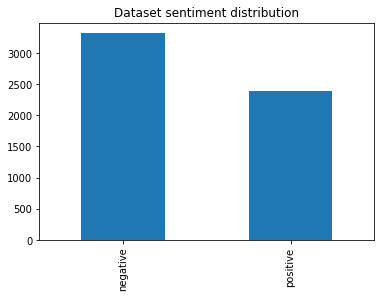

In [5]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

## 3.3 Checkout emotion distribution

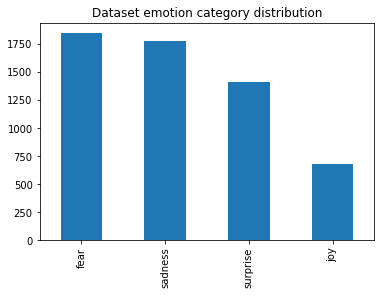

In [6]:
predictions.emotion.value_counts().plot.bar(title='Dataset emotion category distribution')

# 4.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [7]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.electra_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])
mat.shape

(5703, 256)

## 4.1 Fit and transform T-SNE algorithm


In [8]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (5703, 2)


### Set plotting styles

In [9]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


# 6.1 Plot low dimensional T-SNE ELECTRA embeddings with hue for POS


Text(0.5, 1.0, 'T-SNE ELECTRA Embeddings, colored by Part of Speech Tag')

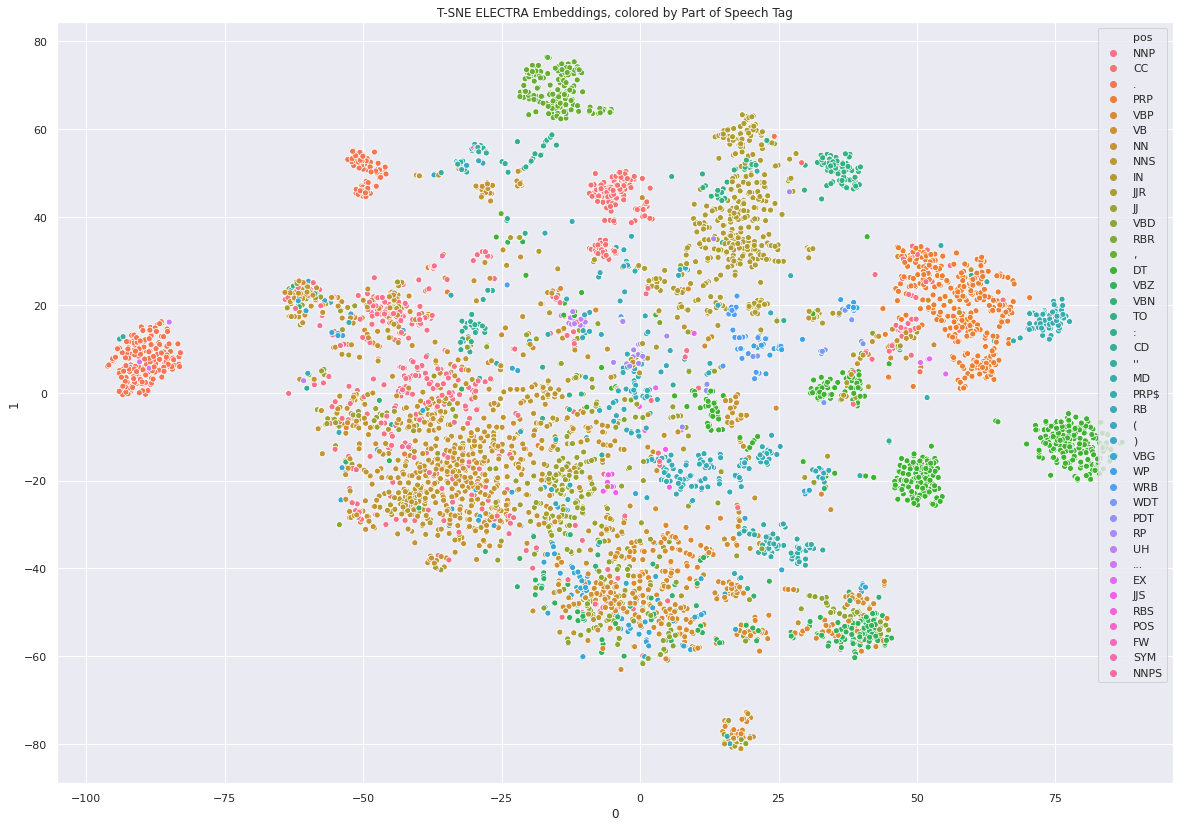

In [10]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.pos)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Embeddings, colored by Part of Speech Tag')


##6.2 Plot low dimensional T-SNE ELECTRA embeddings with hue for Sarcasm


Text(0.5, 1.0, 'T-SNE ELECTRA Embeddings, colored by Sarcasm label')

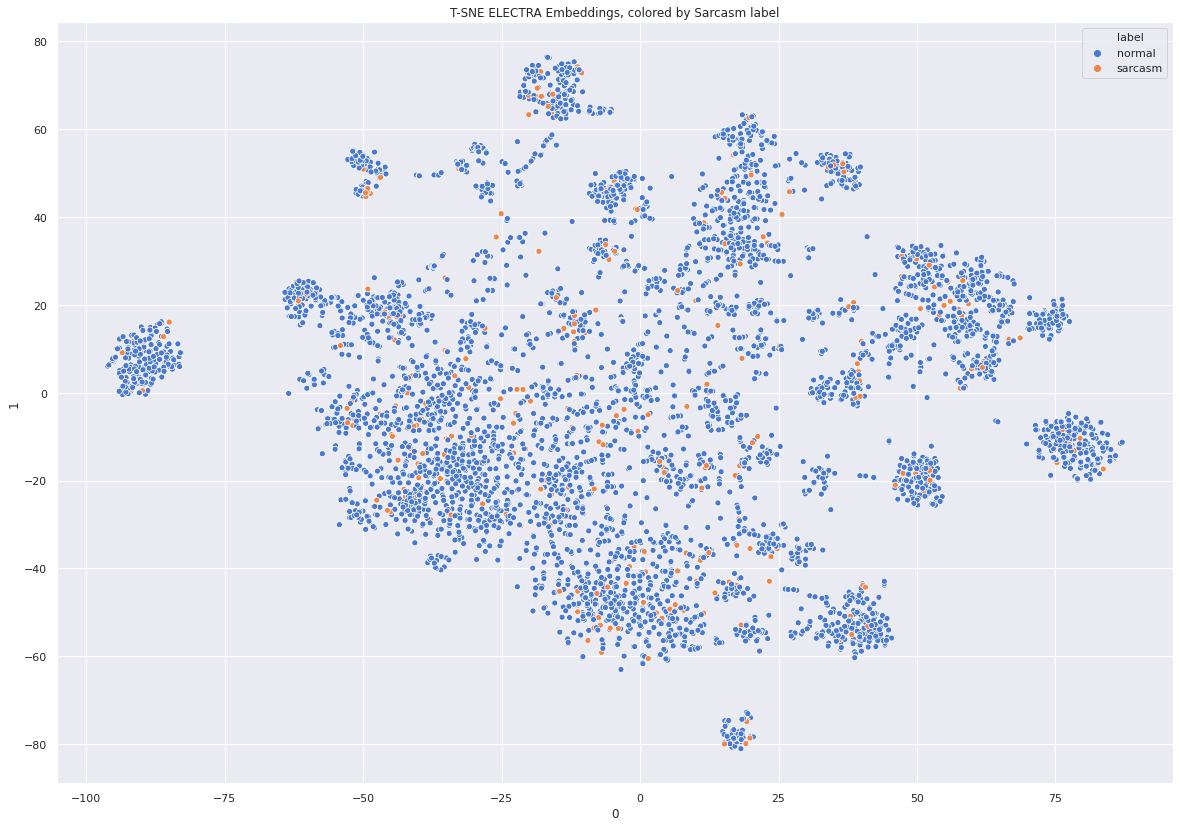

In [11]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Embeddings, colored by Sarcasm label')


## 6.3 Plot low dimensional T-SNE ELECTRA embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE ELECTRA Embeddings, colored by Sentiment')

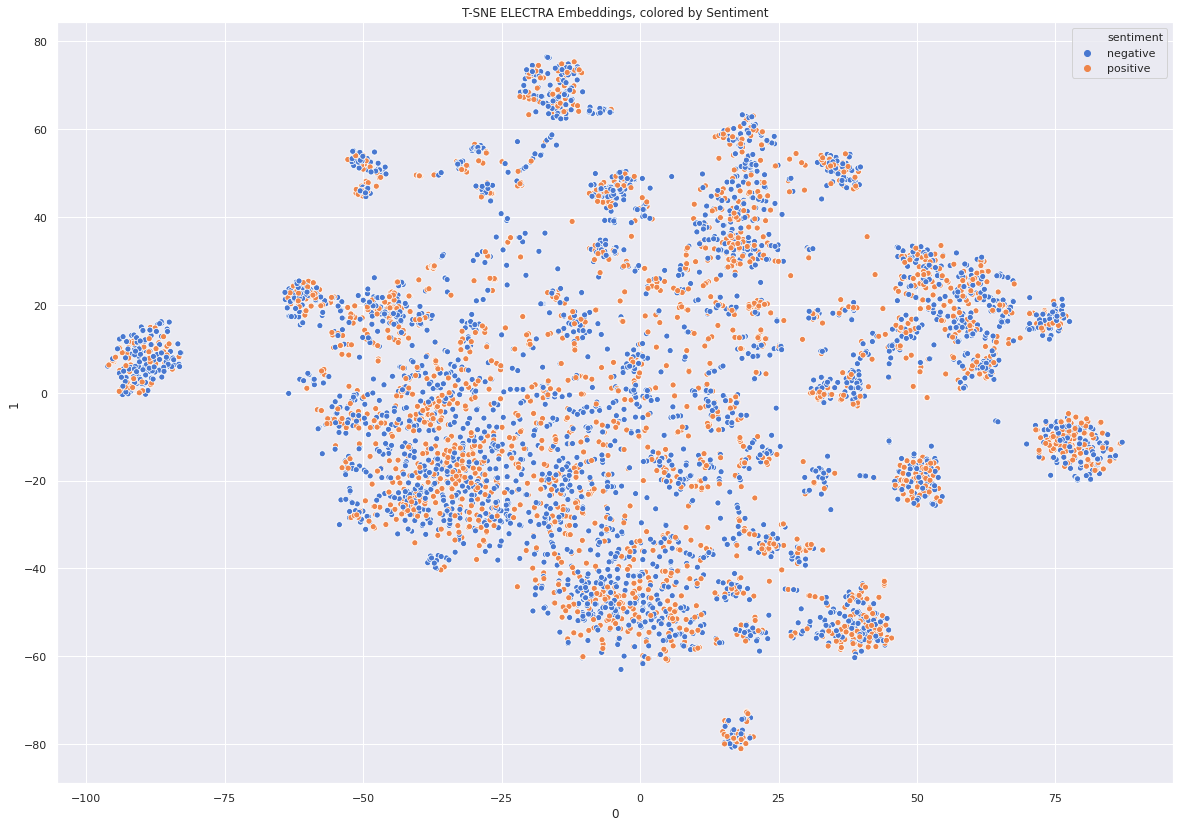

In [12]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Embeddings, colored by Sentiment')


# 6.4 Plot low dimensional T-SNE ELECTRA embeddings with hue for Emotions


Text(0.5, 1.0, 'T-SNE ELECTRA Embeddings, colored by Emotion')

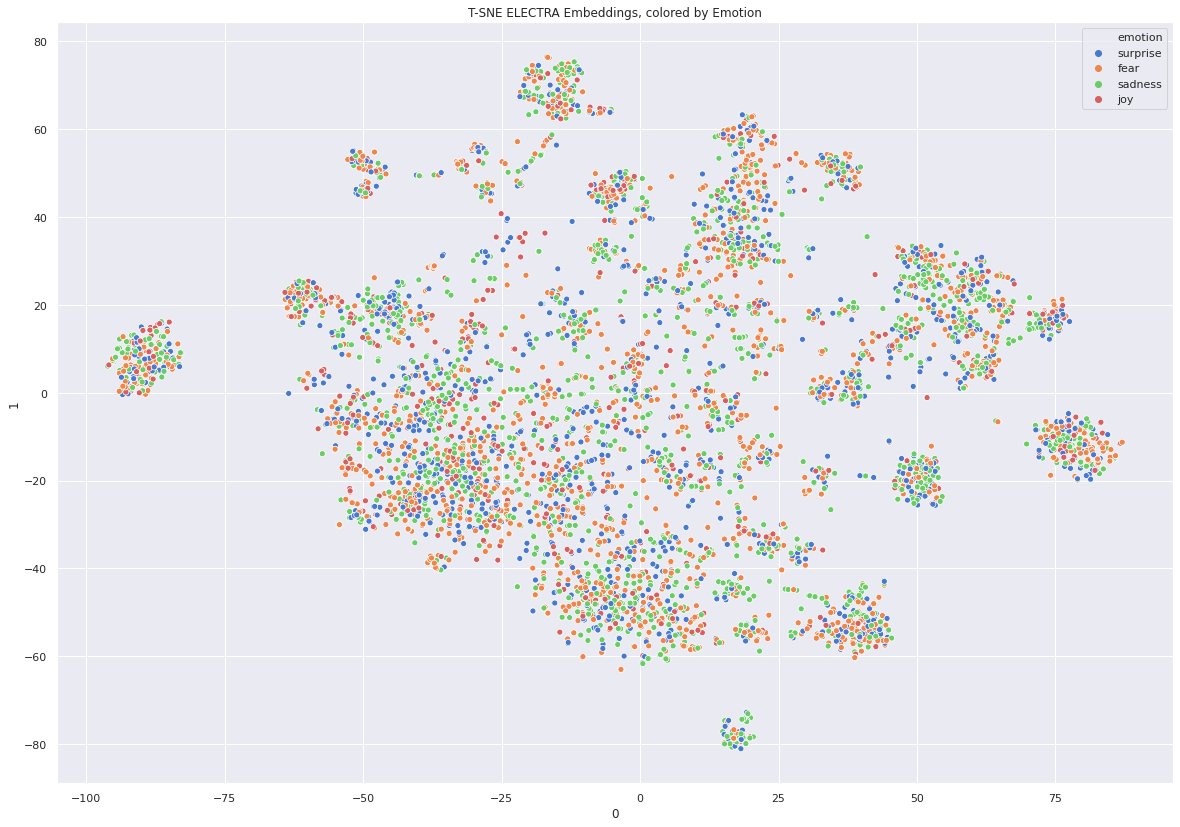

In [13]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.emotion)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Embeddings, colored by Emotion')


# 7. NLU has many more embedding models!      
Make sure to try them all out!       
You can change 'electra' in nlu.load('electra') to bert, xlnet, albert or any other of the **100+ word embeddings** offerd by NLU

In [14]:
nlu.print_all_model_kinds_for_action('embed')

For language <en> NLU provides the following Models : 
nlu.load('en.embed') returns Spark NLP model glove_100d
nlu.load('en.embed.glove') returns Spark NLP model glove_100d
nlu.load('en.embed.glove.100d') returns Spark NLP model glove_100d
nlu.load('en.embed.bert') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_uncased') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_cased') returns Spark NLP model bert_base_cased
nlu.load('en.embed.bert.large_uncased') returns Spark NLP model bert_large_uncased
nlu.load('en.embed.bert.large_cased') returns Spark NLP model bert_large_cased
nlu.load('en.embed.biobert') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_base_cased') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_large_cased') returns Spark NLP model biobert_pubmed_large_cased
nlu.load('en.embed.biobert.pmc_base_cased') returns Spark NLP model biobert_pmc_base_cased
nlu.lo